## Talent acquisition using NLP techniques where we will get help using LLMs to find candidates with matching skills

modules to be installed

In [ ]:
#!pip install accelerate peft bitsandbytes transformers trl

### Adding libraries as a first step

In [27]:
#using gensim for word embeddings and pandas for data manipulation
import gensim
import pandas as pd
from gensim import corpora
from gensim import models
from gensim import similarities

### adding libraries for wordcloud visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

### adding libraries for store vectors & metadata
import faiss
import numpy as np
import pandas as pd
import pickle
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

### import functions from functions.py
from functions import *


In [28]:

### loading the data
df_pt = pd.read_csv("../data/potential-talents.csv")
df_pt.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [29]:
df_pt.columns

Index(['id', 'job_title', 'location', 'connection', 'fit'], dtype='object')

In [30]:
# ### Data Preprocessing
# import re
# def preprocess_text(text):
#     # Lowercase
#     text = text.lower()
#     # Remove special characters and digits
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     # Remove extra spaces
#     text = re.sub(r'\s+', ' ', text).strip()
#     return text

### starting with Exploratory data analaysis to know more about data 

In [31]:
df_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [32]:
### EDA
columns = df_pt.columns.tolist()
id = columns[0]
job_title = columns[1]
location = columns[2]
connection = columns[3]
fit = columns[4]

for cols in [id, job_title, location, connection]:
    print(f" null values in column {cols}: {df_pt[cols].isnull().sum()}")
    # print(f"{cols}: {df_pt[cols].nunique()}")
    # print(df_pt[cols].value_counts())
    #print("\n")



 null values in column id: 0
 null values in column job_title: 0
 null values in column location: 0
 null values in column connection: 0


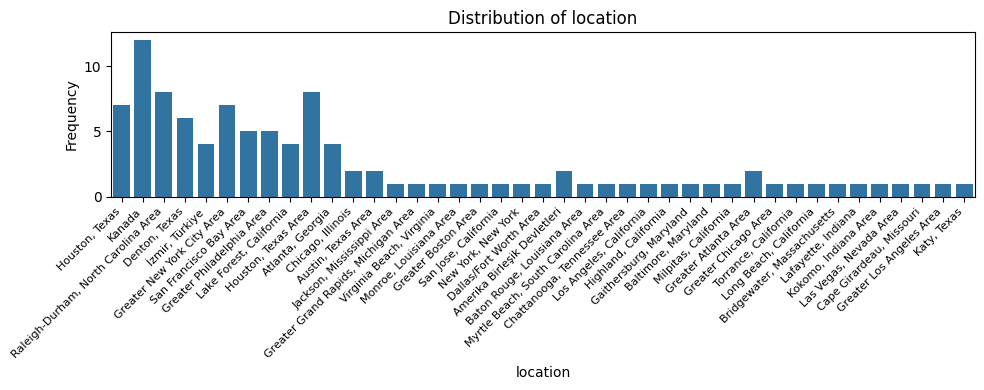

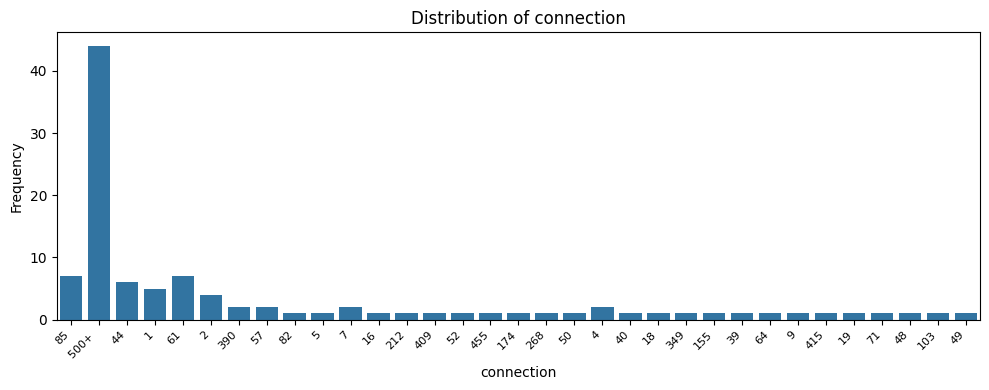

In [33]:

for col in ['location', 'connection']:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df_pt, x=col)
    
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.tight_layout()
    
    plt.savefig(f'../images/{col}_distribution.png')
    plt.show()



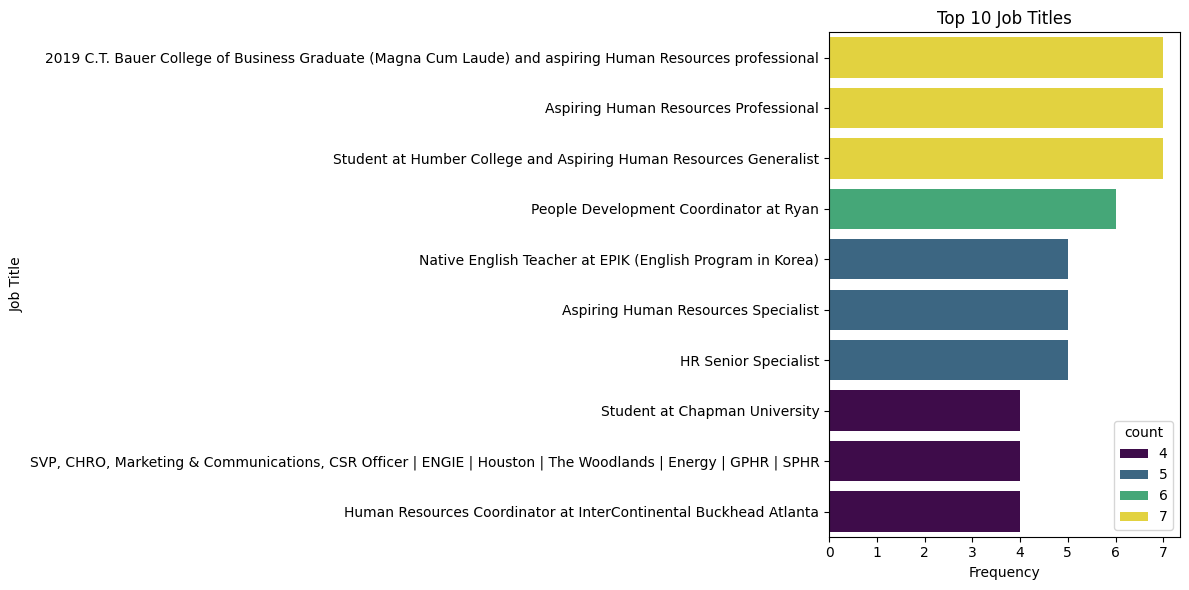

In [34]:
## plot frequency of job titles
plt.figure(figsize=(12, 6))
top_job_titles = df_pt['job_title'].value_counts().nlargest(10)
sns.barplot(x=top_job_titles.values, y=top_job_titles.index, hue=top_job_titles, palette='viridis')
plt.title('Top 10 Job Titles')
plt.xlabel('Frequency')
plt.ylabel('Job Title')
plt.tight_layout()
plt.savefig('../images/top_10_job_titles.png')

In [35]:
df_pt['cleaned_job_title'] = df_pt['job_title'].apply(preprocess_text)
df_pt.head()

,id,job_title,location,connection,fit,cleaned_job_title
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,ct bauer college of business graduate magna cu...
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher at epik english program...
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resources professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator at ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member at celal bayar university


### using gensim to help with the semantic search

In [36]:
job_title = df_pt['job_title'].apply(gensim.utils.simple_preprocess)
job_title[:5]

0    [bauer, college, of, business, graduate, magna...
1    [native, english, teacher, at, epik, english, ...
2           [aspiring, human, resources, professional]
3         [people, development, coordinator, at, ryan]
4    [advisory, board, member, at, celal, bayar, un...
Name: job_title, dtype: object

### creating a wordcloud to get an idea about the most commonly used/available job titles

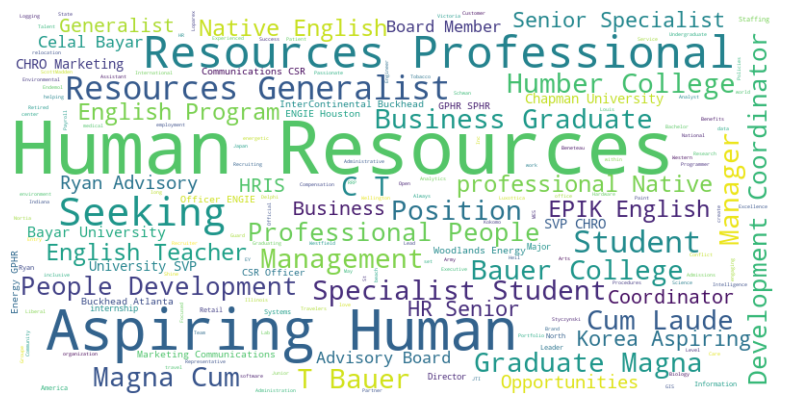

<Figure size 640x480 with 0 Axes>

In [37]:
job_titles_list = job_title.tolist()
text = " ".join(df_pt['job_title'])
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.savefig('../images/job_title_wordcloud.png')

In [38]:
job_title[0]

['bauer',
 'college',
 'of',
 'business',
 'graduate',
 'magna',
 'cum',
 'laude',
 'and',
 'aspiring',
 'human',
 'resources',
 'professional']

In [39]:
print(gensim.parsing.preprocessing.STOPWORDS)

frozenset({'top', 'using', 'sometime', 'toward', 'beforehand', 'eleven', 'until', 'than', 'behind', 'km', 'together', 'thereupon', 'do', 'yourself', 'last', 'namely', 'and', 'he', 'used', 'fifty', 'are', 'anything', 'find', 'often', 'made', 'really', 'hence', 'with', 'throughout', 'never', 'through', 'ie', 'meanwhile', 'unless', 'indeed', 'done', 'regarding', 'that', 'somehow', 'eight', 'mine', 'me', 'mostly', 'between', 'seems', 'yet', 'how', 'ever', 'give', 'anywhere', 'out', 'make', 'ten', 'sometimes', 'whence', 'first', 'us', 'all', 'be', 'always', 'any', 'next', 'fill', 'five', 'con', 'why', 'whom', 'one', 'inc', 'whose', 'latter', 'enough', 'during', 'from', 'thick', 'towards', 'down', 'someone', 'take', 'sincere', 'bill', 'few', 'him', 'might', 'too', 'has', 'almost', 'herself', 'thereafter', 'serious', 'along', 'fifteen', 'sixty', 'against', 'less', 'whereby', 'whereupon', 'everything', 'alone', 'other', 'became', 'herein', 'others', 'these', 'see', 'everyone', 'full', 'seem', 

### finding stop words in job titles

In [40]:
# create a set of frequently used words
stop_words = set(gensim.parsing.preprocessing.STOPWORDS)
# stop_words = set('for a of the and to in'.split(' '))
# texts = [[word for word in doc if word not in stop_words] for doc in job_title]
texts = [[word for word in doc if word not in stop_words] for doc in job_title]
# count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]
print(processed_corpus[:5])

[['bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resources', 'professional'], ['native', 'english', 'teacher', 'epik', 'english', 'program', 'korea'], ['aspiring', 'human', 'resources', 'professional'], ['people', 'development', 'coordinator', 'ryan'], ['advisory', 'board', 'member', 'celal', 'bayar', 'university']]


In [41]:
print(processed_corpus)

[['bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resources', 'professional'], ['native', 'english', 'teacher', 'epik', 'english', 'program', 'korea'], ['aspiring', 'human', 'resources', 'professional'], ['people', 'development', 'coordinator', 'ryan'], ['advisory', 'board', 'member', 'celal', 'bayar', 'university'], ['aspiring', 'human', 'resources', 'specialist'], ['student', 'humber', 'college', 'aspiring', 'human', 'resources', 'generalist'], ['hr', 'senior', 'specialist'], ['student', 'humber', 'college', 'aspiring', 'human', 'resources', 'generalist'], ['seeking', 'human', 'resources', 'hris', 'generalist', 'positions'], ['student', 'chapman', 'university'], ['svp', 'chro', 'marketing', 'communications', 'csr', 'officer', 'engie', 'houston', 'woodlands', 'energy', 'gphr', 'sphr'], ['human', 'resources', 'coordinator', 'buckhead', 'atlanta'], ['bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resou

In [42]:

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)
print(dictionary.token2id)

Dictionary<65 unique tokens: ['aspiring', 'bauer', 'business', 'college', 'cum']...>
{'aspiring': 0, 'bauer': 1, 'business': 2, 'college': 3, 'cum': 4, 'graduate': 5, 'human': 6, 'laude': 7, 'magna': 8, 'professional': 9, 'resources': 10, 'english': 11, 'epik': 12, 'korea': 13, 'native': 14, 'program': 15, 'teacher': 16, 'coordinator': 17, 'development': 18, 'people': 19, 'ryan': 20, 'advisory': 21, 'bayar': 22, 'board': 23, 'celal': 24, 'member': 25, 'university': 26, 'specialist': 27, 'generalist': 28, 'humber': 29, 'student': 30, 'hr': 31, 'senior': 32, 'hris': 33, 'positions': 34, 'seeking': 35, 'chapman': 36, 'chro': 37, 'communications': 38, 'csr': 39, 'energy': 40, 'engie': 41, 'gphr': 42, 'houston': 43, 'marketing': 44, 'officer': 45, 'sphr': 46, 'svp': 47, 'woodlands': 48, 'atlanta': 49, 'buckhead': 50, 'internship': 51, 'management': 52, 'opportunities': 53, 'manager': 54, 'retail': 55, 'staffing': 56, 'america': 57, 'director': 58, 'north': 59, 'position': 60, 'major': 61, '

In [43]:
print(len(dictionary))

65


In [44]:
bow_corpus =[dictionary.doc2bow(text) for text in processed_corpus]
print(bow_corpus[:5])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)], [(11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)], [(0, 1), (6, 1), (9, 1), (10, 1)], [(17, 1), (18, 1), (19, 1), (20, 1)], [(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]]


In [45]:
# train the model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    print(doc)

[(0, 0.15409025871479304), (1, 0.38181197519664134), (2, 0.31785994113068355), (3, 0.28373757014367385), (4, 0.38181197519664134), (5, 0.38181197519664134), (6, 0.07548810304306029), (7, 0.38181197519664134), (8, 0.38181197519664134), (9, 0.2332711123621775), (10, 0.07548810304306029)]
[(11, 0.6666666666666667), (12, 0.33333333333333337), (13, 0.33333333333333337), (14, 0.33333333333333337), (15, 0.33333333333333337), (16, 0.33333333333333337)]
[(0, 0.514905501818844), (6, 0.252249817106758), (9, 0.7794949542722511), (10, 0.252249817106758)]
[(17, 0.4282922112779002), (18, 0.5217169672528987), (19, 0.5217169672528987), (20, 0.5217169672528987)]
[(21, 0.42877361248588103), (22, 0.42877361248588103), (23, 0.42877361248588103), (24, 0.42877361248588103), (25, 0.42877361248588103), (26, 0.28419350129627785)]
[(0, 0.4298555394513991), (6, 0.2105842350216153), (10, 0.2105842350216153), (27, 0.8523689196138423)]
[(0, 0.24004117745157263), (3, 0.4420052311716772), (6, 0.1175950594747249), (10,

### creating an index of similarities from the corpus

In [46]:
index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=len(dictionary))

In [47]:
query_doc = "Aspiring Human Resources Specialist".lower()
query_bow = dictionary.doc2bow(gensim.utils.simple_preprocess(query_doc))
similarity = index[tfidf[query_bow]]
print(similarity)

[0.09802976 0.         0.32757464 0.         0.         0.9999999
 0.15271038 0.40225926 0.15271038 0.04132142 0.         0.
 0.04301821 0.09802976 0.09802976 0.         0.32757464 0.
 0.09802976 0.         0.32757464 0.         0.         0.9999999
 0.15271038 0.40225926 0.12709105 0.05814571 0.12709105 0.05814571
 0.09802976 0.         0.32757464 0.         0.         0.9999999
 0.15271038 0.40225926 0.15271038 0.04132142 0.         0.
 0.04301821 0.09802976 0.         0.32757464 0.         0.
 0.9999999  0.15271038 0.40225926 0.15271038 0.04132142 0.
 0.         0.04301821 0.09802976 0.32757464 0.         0.9999999
 0.40225926 0.04132142 0.         0.         0.04301821 0.13243726
 0.05168647 0.90289766 0.03373469 0.04570235 0.10487389 0.11745628
 0.1763608  0.12393124 0.05033144 0.32757464 0.03904483 0.10487389
 0.18303634 0.         0.06058946 0.15459102 0.         0.05168647
 0.         0.30725774 0.         0.04871079 0.06198353 0.
 0.         0.         0.         0.05814571 0.

In [48]:
## top 10 similar documents
top_10 = sorted(enumerate(similarity), key=lambda item: -item[1])[:10]
print("Top 10 similar documents (index, similarity score):")
for doc_position, doc_score in top_10:
    print(f"Document {doc_position}: Similarity Score {doc_score}")

Top 10 similar documents (index, similarity score):
Document 5: Similarity Score 0.9999998807907104
Document 23: Similarity Score 0.9999998807907104
Document 35: Similarity Score 0.9999998807907104
Document 48: Similarity Score 0.9999998807907104
Document 59: Similarity Score 0.9999998807907104
Document 67: Similarity Score 0.9028976559638977
Document 7: Similarity Score 0.4022592604160309
Document 25: Similarity Score 0.4022592604160309
Document 37: Similarity Score 0.4022592604160309
Document 50: Similarity Score 0.4022592604160309


In [49]:
for i, sim in sorted(enumerate(similarity), key=lambda item: -item[1], reverse=False):
    print(f"Document {i}: Similarity {sim}")

Document 5: Similarity 0.9999998807907104
Document 23: Similarity 0.9999998807907104
Document 35: Similarity 0.9999998807907104
Document 48: Similarity 0.9999998807907104
Document 59: Similarity 0.9999998807907104
Document 67: Similarity 0.9028976559638977
Document 7: Similarity 0.4022592604160309
Document 25: Similarity 0.4022592604160309
Document 37: Similarity 0.4022592604160309
Document 50: Similarity 0.4022592604160309
Document 60: Similarity 0.4022592604160309
Document 2: Similarity 0.32757464051246643
Document 16: Similarity 0.32757464051246643
Document 20: Similarity 0.32757464051246643
Document 32: Similarity 0.32757464051246643
Document 45: Similarity 0.32757464051246643
Document 57: Similarity 0.32757464051246643
Document 75: Similarity 0.32757464051246643
Document 96: Similarity 0.32757464051246643
Document 85: Similarity 0.307257741689682
Document 78: Similarity 0.18303634226322174
Document 72: Similarity 0.17636080086231232
Document 99: Similarity 0.17636080086231232
Docu

In [50]:
for doc, as_text in zip(df_pt['job_title'], top_10):
    print(f"Document: {doc} \nSimilarity Score: {as_text}\n")

Document: 2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional 
Similarity Score: (5, 0.9999999)

Document: Native English Teacher at EPIK (English Program in Korea) 
Similarity Score: (23, 0.9999999)

Document: Aspiring Human Resources Professional 
Similarity Score: (35, 0.9999999)

Document: People Development Coordinator at Ryan 
Similarity Score: (48, 0.9999999)

Document: Advisory Board Member at Celal Bayar University 
Similarity Score: (59, 0.9999999)

Document: Aspiring Human Resources Specialist 
Similarity Score: (67, 0.90289766)

Document: Student at Humber College and Aspiring Human Resources Generalist 
Similarity Score: (7, 0.40225926)

Document: HR Senior Specialist 
Similarity Score: (25, 0.40225926)

Document: Student at Humber College and Aspiring Human Resources Generalist 
Similarity Score: (37, 0.40225926)

Document: Seeking Human Resources HRIS and Generalist Positions 
Similarity Score: (50, 0.40225926)



### Using sentence transformer model all-mpnet-base-v2 to produce embeddings and for semantic serach 

In [51]:
from sentence_transformers import SentenceTransformer, util

model_tf = SentenceTransformer("all-mpnet-base-v2")

query = "Aspiring Human Resources Professional | An energetic and Team-Focused Leader"
docs = df_pt['job_title'].tolist()
embeddings = model_tf.encode(docs, convert_to_tensor=True)
query_embedding = model_tf.encode(query, convert_to_tensor=True)

scores = util.cos_sim(query_embedding, embeddings)
### print scores of each document along with document for top 10
top_10_indices = np.argsort(-scores[0].cpu().numpy())[:10]
top_10_scores = scores[0][top_10_indices]
top_10_docs = [docs[i] for i in top_10_indices]

# for score, doc, index in zip(top_10_scores, top_10_docs, top_10_indices):
#     print(f"Score: {score:.4f}\tDocument: {doc}\tIndex: {docs.index(doc)}")

for score, doc, index in zip(top_10_scores, top_10_docs, top_10_indices):
    print(f"Score: {score:.4f}\tDocument: {doc}\tIndex: {index}")




Score: 1.0000	Document: Aspiring Human Resources Professional | An energetic and Team-Focused Leader	Index: 81
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 20
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 45
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 32
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 57
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 16
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 2
Score: 0.8231	Document: Aspiring Human Resources Professional	Index: 96
Score: 0.7780	Document: Aspiring Human Resources Professional | Passionate about helping to create an inclusive and engaging work environment	Index: 75
Score: 0.7595	Document: Aspiring Human Resources Specialist	Index: 35


In [52]:
embeddings.shape

torch.Size([104, 768])

In [53]:
np.save('../embeddings/pt_job_title_embeddings_model_tf.npy', embeddings)

In [54]:
# loading the embeddings
embeddings = np.load('../embeddings/pt_job_title_embeddings_model_tf.npy')

In [55]:
shape = embeddings.shape
print('shape of embeddings: ',shape)
d = embeddings.shape[1]  # dimension of the embeddings
print('dimensionality of each embedding vector: ',d)

shape of embeddings:  (104, 768)
dimensionality of each embedding vector:  768


### using faiss vector search library for a fast similarity seach

In [65]:
import faiss
import pickle
from sentence_transformers import SentenceTransformer

Build an index (store vector & metadata)

In [66]:
MODEL_NAME = "intfloat/e5-base-v2"   # great for retrieval; or "all-mpnet-base-v2"
INDEX_PATH = "../data/jd_model_e5.index"
META_PATH  = "../data/jd_meta_model_e5.pkl"

model = SentenceTransformer(MODEL_NAME)
#docs = ["passage: " + t for t in df_pt["job_title"].tolist()]
docs = (
    "passage: " +
    df_pt.astype(str)
         .apply(lambda r: " | ".join(f"{c}: {r[c]}" for c in df_pt.columns), axis=1)
).tolist()

emb = model.encode(docs, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
emb = emb.astype("float32")

## saving embeddings
np.save('../embeddings/pt_job_title_embeddings_model_e5.npy', emb)

d = emb.shape[1]  # vector dimension

# Cosine similarity = inner product when vectors are normalized
index = faiss.IndexFlatIP(d)
index.add(emb)


# Save
faiss.write_index(index, INDEX_PATH)
with open(META_PATH, "wb") as f:
    pickle.dump(df_pt.to_dict(orient="records"), f)

print(f"Indexed {index.ntotal} job descriptions. dim={d}")

Batches: 100%|██████████| 2/2 [00:19<00:00,  9.80s/it]

Indexed 104 job descriptions. dim=768


Search (semantic matching)

In [59]:
# def search_by_vector(
#     qv,
#     top_k=10,
#     retrieve_k=200,
#     min_score=None,          # e.g. 0.35; or None to disable
#     rel_drop=None,           # e.g. 0.10 keeps results within 0.10 of best
#     location_preference=None,# e.g. "london" (already normalized)
#     location_penalty=0.08,   # subtract if mismatch
#     location_boost=0.02,     # add if match
#     title_terms=None,        # list[str] tokens to boost when present
#     title_boost=0.02
# ):
#     # Ensure qv shape (1, d) and normalized for cosine/IP
#     qv = normalize(qv).reshape(1, -1).astype("float32")
#     scores, idxs = index.search(qv, retrieve_k)

#     scores = scores[0]
#     idxs = idxs[0]

#     # If nothing found
#     if len(scores) == 0:
#         return []

#     best = float(scores[0]) if idxs[0] != -1 else None

#     candidates = []
#     for score, i in zip(scores, idxs):
#         if i == -1:
#             continue

#         s = float(score)
#         row = meta[int(i)]

#         # Soft min_score (optional)
#         if min_score is not None and s < float(min_score):
#             continue

#         # Relative drop cutoff (optional)
#         if rel_drop is not None and best is not None and (best - s) > float(rel_drop):
#             continue

#         # --- lightweight rerank adjustments ---
#         adj = 0.0

#         # Location preference
#         if location_preference:
#             job_loc = (row.get("location") or "").strip().lower()
#             # if you have location_norm in meta, use that instead
#             if location_preference in job_loc:
#                 adj += location_boost
#             else:
#                 adj -= location_penalty

#         # Title term boost
#         if title_terms:
#             jt = (row.get("job_title") or "").lower()
#             if any(t.lower() in jt for t in title_terms):
#                 adj += title_boost

#         final_score = s + adj

#         candidates.append((final_score, s, int(i), row))

#     # Sort by reranked score
#     candidates.sort(key=lambda x: x[0], reverse=True)

#     # Build output
#     results = []
#     for rank, (final_score, raw_score, i, row) in enumerate(candidates[:top_k], start=1):
#         results.append({
#             "rank": rank,
#             "id": row.get("id"),
#             "faiss_id": i,
#             "score": round(float(final_score), 4),
#             "raw_score": round(float(raw_score), 4),
#             "job_title": row.get("job_title"),
#             "location": row.get("location"),
#         })

#     return results


In [60]:
# import numpy as np

# def normalize(v: np.ndarray) -> np.ndarray:
#      v = v.astype(np.float32)
#      norm = np.linalg.norm(v)
#      if norm == 0:
#          return v
#      return v / norm


In [71]:
## ask user for querytext input
# querytext = "Looking for a Software Engineer with experience in Python and Machine Learning."
# print(f"input query: {querytext}")


print(f'enter a job title to search:')
querytext = input()
print(f"you want to search the job title: {querytext}")

# querytext = input("Enter a job title to search: ").strip()
# location = input("Preferred location (optional): ").strip()

# print(f"Searching for: {querytext}" + (f" in {location}" if location else ""))

# e5_query = f"query: Target title: {querytext}. " + (f"Preferred location: {location}. " if location else "")


enter a job title to search:
you want to search the job title: Human resource manager


In [73]:
print (querytext)

Human resource manager


In [78]:
# Reload functions module to get updated search_by_vector
import importlib
import functions
importlib.reload(functions)

# Load the FAISS index and metadata
index = faiss.read_index(INDEX_PATH)
with open(META_PATH, "rb") as f:
    meta = pickle.load(f)

# Create query vector from querytext
qv_base = functions.normalize(
    model.encode(["query: " + querytext], normalize_embeddings=True)[0]
)

# Search using the query vector, passing index and meta
results = functions.search_by_vector(qv_base, index_obj=index, meta_obj=meta, top_k=10, retrieve_k=50)
for r in results:
    print(r)

{'rank': 1, 'id': 73, 'faiss_id': 72, 'score': 0.8614, 'raw_score': 0.8614, 'job_title': 'Aspiring Human Resources Manager, seeking internship in Human Resources.', 'location': 'Houston, Texas Area'}
{'rank': 2, 'id': 100, 'faiss_id': 99, 'score': 0.8565, 'raw_score': 0.8565, 'job_title': 'Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis', 'location': 'Cape Girardeau, Missouri'}
{'rank': 3, 'id': 72, 'faiss_id': 71, 'score': 0.843, 'raw_score': 0.843, 'job_title': 'Business Management Major and Aspiring Human Resources Manager', 'location': 'Monroe, Louisiana Area'}
{'rank': 4, 'id': 82, 'faiss_id': 81, 'score': 0.8427, 'raw_score': 0.8427, 'job_title': 'Aspiring Human Resources Professional | An energetic and Team-Focused Leader', 'location': 'Austin, Texas Area'}
{'rank': 5, 'id': 66, 'faiss_id': 65, 'score': 0.8398, 'raw_score': 0.8398, 'job_title': 'Experienced Retail Manager and aspiring Human Resources Professio

In [79]:
## pretty print results
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results)



[   {   'faiss_id': 72,
        'id': 73,
        'job_title': 'Aspiring Human Resources Manager, seeking internship in '
                     'Human Resources.',
        'location': 'Houston, Texas Area',
        'rank': 1,
        'raw_score': 0.8614,
        'score': 0.8614},
    {   'faiss_id': 99,
        'id': 100,
        'job_title': 'Aspiring Human Resources Manager | Graduating May 2020 | '
                     'Seeking an Entry-Level Human Resources Position in St. '
                     'Louis',
        'location': 'Cape Girardeau, Missouri',
        'rank': 2,
        'raw_score': 0.8565,
        'score': 0.8565},
    {   'faiss_id': 71,
        'id': 72,
        'job_title': 'Business Management Major and Aspiring Human Resources '
                     'Manager',
        'location': 'Monroe, Louisiana Area',
        'rank': 3,
        'raw_score': 0.843,
        'score': 0.843},
    {   'faiss_id': 81,
        'id': 82,
        'job_title': 'Aspiring Human Resources Profe

In [80]:
## save from json to dataframe
import pandas as pd
df_results = pd.DataFrame(results, columns=["score","faiss_id", "id", "job_title", "location"])
df_results

,score,faiss_id,id,job_title,location
0,0.8614,72,73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area"
1,0.8565,99,100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri"
2,0.8430,71,72,Business Management Major and Aspiring Human R...,"Monroe, Louisiana Area"
3,0.8427,81,82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area"
4,0.8398,65,66,Experienced Retail Manager and aspiring Human ...,"Austin, Texas Area"
5,0.8394,82,83,HR Manager at Endemol Shine North America,"Los Angeles, California"
6,0.8382,76,77,Human Resources|\nConflict Management|\nPolici...,Dallas/Fort Worth Area
7,0.8360,87,88,Human Resources Management Major,"Milpitas, California"
8,0.8351,28,29,Aspiring Human Resources Management student se...,"Houston, Texas Area"
9,0.8351,26,27,Aspiring Human Resources Management student se...,"Houston, Texas Area"


In [81]:
### asking user which candiate to stare for re-rank and save to variable

print(f'enter a number between 0 and {len(results)-1} to select a candidate to re-rank:')
selected_index = int(input())


print(f'You selected candidate at index {selected_index}:')
results[ selected_index ]

enter a number between 0 and 9 to select a candidate to re-rank:
You selected candidate at index 7:


{'rank': 8,
 'id': 88,
 'faiss_id': 87,
 'score': 0.836,
 'raw_score': 0.836,
 'job_title': 'Human Resources Management Major',
 'location': 'Milpitas, California'}

In [82]:
# starring the results for re-rank
starred_faiss_id = results[selected_index]["faiss_id"] 

In [83]:
## get starred vector from FAISS
v_star = normalize(index.reconstruct(starred_faiss_id))


In [84]:
alpha = 0.5  # trust in human feedback (0–1)

qv_reranked = normalize((1 - alpha) * qv_base + alpha * v_star)

In [85]:
#results = search_by_vector(qv_base, top_k=10, threshold=0.6, retrieve_k=50)
reranked_results = search_by_vector(qv_reranked, top_k=10, retrieve_k=50)

print("🔁 Re-ranked results:\n")
for r in reranked_results:
    print(f"#{r['rank']:2d} | score={r['score']:.3f} | {r['job_title']} ({r['location']})")

🔁 Re-ranked results:

# 1 | score=0.958 | Human Resources Management Major (Milpitas, California)
# 2 | score=0.906 | Business Management Major and Aspiring Human Resources Manager (Monroe, Louisiana Area)
# 3 | score=0.902 | Aspiring Human Resources Manager, seeking internship in Human Resources. (Houston, Texas Area)
# 4 | score=0.892 | Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis (Cape Girardeau, Missouri)
# 5 | score=0.891 | Aspiring Human Resources Professional | An energetic and Team-Focused Leader (Austin, Texas Area)
# 6 | score=0.889 | Human Resources professional for the world leader in GIS software (Highland, California)
# 7 | score=0.887 | Aspiring Human Resources Management student seeking an internship (Houston, Texas Area)
# 8 | score=0.887 | Experienced Retail Manager and aspiring Human Resources Professional (Austin, Texas Area)
# 9 | score=0.886 | Aspiring Human Resources Management student seeki

### Fine tuning the LLM model

In [26]:
## fine tune the e25 model on potential talent dataset
# !pip install transformers datasets peft bitsandbytes accelerate
import transformers
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
# --- IGNORE ---
from datasets import load_dataset
dataset = load_dataset("csv", data_files="../data/potential-talents.csv")
# --- IGNORE ---
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-base-v2")
model = AutoModelForCausalLM.from_pretrained("intfloat/e5-base-v2", device_map="auto", load_in_8bit=True)
model.config.use_cache = False
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
def tokenize_function(examples):
    return tokenizer(examples["job_title"], truncation=True, max_length=128)
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["id", "job_title", "location", "connection", "fit"])
tokenized_datasets = tokenized_datasets["train"].train_test_split(test_size=0.1)
from peft import LoraConfig, get_peft_model, TaskType
lora_config = LoraConfig(
    r=4,
    lora_alpha=32,
    # e5/BERT layers use query/key/value and intermediate/output dense names
    #target_modules=["query", "key", "value", "intermediate.dense", "output.dense"],
    target_modules=["query", "key"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)
model = get_peft_model(model, lora_config)
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir="./e5-finetuned-pt",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    #evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    #learning_rate=2e-4,
    learning_rate=1e-3,
    weight_decay=0.01,
    warmup_steps=100,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
)
trainer.train()
model.save_pretrained("../models/e5-finetuned-pt")
MODEL_NAME = "intfloat/e5-base-v2"   # great for retrieval; or "all-mpnet-base-v2"
INDEX_PATH = "../data/jd_model_e5.index"
META_PATH  = "../data/jd_meta_model_e5.pkl"
model = SentenceTransformer(MODEL_NAME)
#docs = ["passage: " + t for t in df_pt["job_title"].tolist()]
docs = (
    "passage: " +
    df_pt.astype(str)
         .apply(lambda r: " | ".join(f"{c}: {r[c]}" for c in df_pt.columns), axis=1)
).tolist()



The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of BertLMHeadModel were not initialized from the model checkpoint at intfloat/e5-base-v2 and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\My-PC\miniconda3\envs\tf310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


In [14]:
print(docs[:10])



['passage: id: 1 | job_title: 2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional | location: Houston, Texas | connection: 85 | fit: nan', 'passage: id: 2 | job_title: Native English Teacher at EPIK (English Program in Korea) | location: Kanada | connection: 500+  | fit: nan', 'passage: id: 3 | job_title: Aspiring Human Resources Professional | location: Raleigh-Durham, North Carolina Area | connection: 44 | fit: nan', 'passage: id: 4 | job_title: People Development Coordinator at Ryan | location: Denton, Texas | connection: 500+  | fit: nan', 'passage: id: 5 | job_title: Advisory Board Member at Celal Bayar University | location: İzmir, Türkiye | connection: 500+  | fit: nan', 'passage: id: 6 | job_title: Aspiring Human Resources Specialist | location: Greater New York City Area | connection: 1 | fit: nan', 'passage: id: 7 | job_title: Student at Humber College and Aspiring Human Resources Generalist | location: Kanada | connection:

In [15]:
## asking query again using input and the fine tuned model
querytext = input("Enter a job title to search: ").strip()
location = input("Preferred location (optional): ").strip()

print(f"Searching for: {querytext}" + (f" in {location}" if location else ""))

e5_query = f"query: Target title: {querytext}. " + (f"Preferred location: {location}. " if location else "")
print (e5_query)

Searching for: Aspiring human resource in Denton, Texas
query: Target title: Aspiring human resource. Preferred location: Denton, Texas. 


In [20]:
# Load the FAISS index and metadata
MODEL_PATH = "../models/e5-finetuned-pt"
model = SentenceTransformer(MODEL_PATH)
index = faiss.read_index(INDEX_PATH)
with open(META_PATH, "rb") as f:
    meta = pickle.load(f)

# Create query vector from querytext
qv_base = normalize(
    model.encode(["query: " + querytext], normalize_embeddings=True)[0]
)

# Search using the query vector
results = search_by_vector(qv_base, top_k=10, retrieve_k=50)
for r in results:
    print(r)

{'rank': 1, 'id': 76, 'faiss_id': 75, 'score': 0.8845, 'raw_score': 0.8845, 'job_title': 'Aspiring Human Resources Professional | Passionate about helping to create an inclusive and engaging work environment', 'location': 'New York, New York'}
{'rank': 2, 'id': 17, 'faiss_id': 16, 'score': 0.8836, 'raw_score': 0.8836, 'job_title': 'Aspiring Human Resources Professional', 'location': 'Raleigh-Durham, North Carolina Area'}
{'rank': 3, 'id': 21, 'faiss_id': 20, 'score': 0.8818, 'raw_score': 0.8818, 'job_title': 'Aspiring Human Resources Professional', 'location': 'Raleigh-Durham, North Carolina Area'}
{'rank': 4, 'id': 58, 'faiss_id': 57, 'score': 0.8814, 'raw_score': 0.8814, 'job_title': 'Aspiring Human Resources Professional', 'location': 'Raleigh-Durham, North Carolina Area'}
{'rank': 5, 'id': 82, 'faiss_id': 81, 'score': 0.8811, 'raw_score': 0.8811, 'job_title': 'Aspiring Human Resources Professional | An energetic and Team-Focused Leader', 'location': 'Austin, Texas Area'}
{'rank': 6

In [21]:
### pretty print results
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results)

[   {   'faiss_id': 75,
        'id': 76,
        'job_title': 'Aspiring Human Resources Professional | Passionate about '
                     'helping to create an inclusive and engaging work '
                     'environment',
        'location': 'New York, New York',
        'rank': 1,
        'raw_score': 0.8845,
        'score': 0.8845},
    {   'faiss_id': 16,
        'id': 17,
        'job_title': 'Aspiring Human Resources Professional',
        'location': 'Raleigh-Durham, North Carolina Area',
        'rank': 2,
        'raw_score': 0.8836,
        'score': 0.8836},
    {   'faiss_id': 20,
        'id': 21,
        'job_title': 'Aspiring Human Resources Professional',
        'location': 'Raleigh-Durham, North Carolina Area',
        'rank': 3,
        'raw_score': 0.8818,
        'score': 0.8818},
    {   'faiss_id': 57,
        'id': 58,
        'job_title': 'Aspiring Human Resources Professional',
        'location': 'Raleigh-Durham, North Carolina Area',
        'rank':

In [22]:
## save from json to dataframe
import pandas as pd
df_results_ft = pd.DataFrame(results, columns=["score","faiss_id", "id", "job_title", "location"])
df_results_ft

,score,faiss_id,id,job_title,location
0,0.8845,75,76,Aspiring Human Resources Professional | Passio...,"New York, New York"
1,0.8836,16,17,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area"
2,0.8818,20,21,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area"
3,0.8814,57,58,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area"
4,0.8811,81,82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area"
5,0.8802,32,33,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area"
6,0.8796,45,46,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area"
7,0.8786,2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area"
8,0.8781,23,24,Aspiring Human Resources Specialist,Greater New York City Area
9,0.8769,96,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area"


In [24]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"


In [25]:
print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 109482240
all model parameters: 109482240
percentage of trainable model parameters: 100.00%
